In [19]:
# --- Imports and Setup ---
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from tqdm import tqdm
from glob import glob
from torch.utils.data import DataLoader, TensorDataset
import joblib
import pandas as pd

# Add the src directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
import config
from model import TransformerAutoencoder
from explainability import analyze_anomaly_with_xai
# We only need the benign data loader for this notebook's core function
from data_loader import load_and_preprocess_data

sns.set_style("whitegrid")

In [20]:
# --- Load Benign Data and Then the Trained Model ---
# Load data first to get the correct feature dimension.
try:
    # Correct path for notebook execution
    X_benign_sequences = load_and_preprocess_data()
    X_benign_tensor = torch.tensor(X_benign_sequences, dtype=torch.float32)
    num_features = X_benign_sequences.shape[2]
    print(f"Benign data loaded. Shape: {X_benign_tensor.shape}. Features: {num_features}")
except FileNotFoundError:
    print("Processed benign data not found. Please run `python src/data_loader.py` first to generate it.")
    X_benign_tensor = None
    num_features = config.INPUT_FEATURES # Fallback

# Load the model
if X_benign_tensor is not None:
    model = TransformerAutoencoder(
        input_features=num_features,
        model_dim=config.MODEL_DIM,
        num_heads=config.NUM_HEADS,
        num_encoder_layers=config.NUM_ENCODER_LAYERS,
        dim_feedforward=config.DIM_FEEDFORWARD,
        dropout=config.DROPOUT
    ).to(config.DEVICE)
    try:
        # Correct path for notebook execution
        model_path = os.path.join('..', config.MODEL_SAVE_PATH)
        model.load_state_dict(torch.load(model_path, map_location=config.DEVICE))
        model.eval()
        print("Trained model loaded successfully.")
    except FileNotFoundError:
        print(f"Model not found at {model_path}. Please run `python src/train.py` first.")
        model = None
else:
    model = None

Preprocessed benign data and scaler found. Loading from cache...
Benign data loaded. Shape: torch.Size([56326, 100, 84]). Features: 84
Trained model loaded successfully.


Calculating Reconstruction Errors: 100%|██████████| 40/40 [00:02<00:00, 14.82it/s]


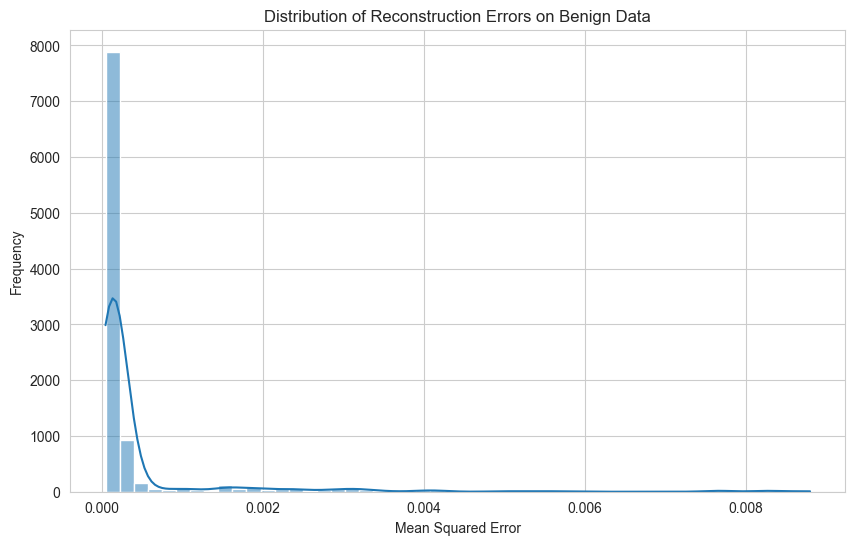

99th percentile of reconstruction errors: 0.005902
A good starting threshold for anomaly detection could be around 0.005902


In [23]:
# --- Calculate and Visualize Reconstruction Errors ---
# This is crucial for setting the anomaly detection threshold.
benign_reconstruction_errors = []
threshold = None

if model and X_benign_tensor is not None:
    with torch.no_grad():
        # Use a dataloader for efficient batch processing
        dataset = TensorDataset(X_benign_tensor[:10000])
        loader = DataLoader(dataset, batch_size=256)
        
        for batch in tqdm(loader, desc="Calculating Reconstruction Errors"):
            seqs = batch[0].to(config.DEVICE)
            reconstructions = model(seqs)
            errors = torch.mean((seqs - reconstructions) ** 2, dim=(1, 2))
            benign_reconstruction_errors.extend(errors.cpu().numpy())

    plt.figure(figsize=(10, 6))
    sns.histplot(benign_reconstruction_errors, bins=50, kde=True)
    plt.title('Distribution of Reconstruction Errors on Benign Data')
    plt.xlabel('Mean Squared Error')
    plt.ylabel('Frequency')
    plt.show()

    threshold = np.percentile(benign_reconstruction_errors, 99)
    print(f"99th percentile of reconstruction errors: {threshold:.6f}")
    print(f"A good starting threshold for anomaly detection could be around {threshold:.6f}")


In [4]:
# --- Analyze a Synthetic Anomaly ---
# This cell creates a noisy sequence to quickly test the XAI functionality.
if model:
    print("\n--- Analyzing a Synthetic Anomaly ---")
    if X_benign_tensor is not None:
        benign_sequence = X_benign_tensor[0].numpy()
        noise = np.random.normal(0, 0.8, size=benign_sequence.shape)
        simulated_anomaly = benign_sequence + noise
        
        print("Generating attention map for a synthetic (noisy) anomaly...")
        analyze_anomaly_with_xai(model, simulated_anomaly, "Synthetic_Noise")
        plt.show() # Display the plot in the notebook
    else:
        print("Benign data not loaded, skipping synthetic anomaly analysis.")


--- Analyzing a Synthetic Anomaly ---
Generating attention map for a synthetic (noisy) anomaly...

Attention heatmap for 'Synthetic_Noise' saved to: results/attention_heatmap_Synthetic_Noise.png


In [5]:
# --- Analyze a Real Attack Vector from an Individual Cache File ---
# This cell now finds and loads one of the specific attack cache files.
if model:
    print("\n--- Analyzing a Real Attack Vector for Each Attack Type ---")
    try:
        # Find available attack cache files
        attack_files_path = os.path.join('..', config.PROCESSED_DATA_DIR, 'X_attack_*.npy')
        attack_files = glob(attack_files_path)
        
        if not attack_files:
            raise FileNotFoundError("No attack cache files found. Run `src/data_loader.py` to create them.")

        # Loop through each attack file and generate a heatmap
        for attack_file_to_analyze in attack_files:
            attack_type = os.path.basename(attack_file_to_analyze).replace('X_attack_', '').replace('.npy', '')
            
            print(f"\nLoading attack data for '{attack_type}' from {attack_file_to_analyze}...")
            attack_sequences = np.load(attack_file_to_analyze)
            
            if attack_sequences.shape[0] > 0:
                # Get a random sequence from the attack data
                random_index = np.random.randint(0, len(attack_sequences))
                real_attack_sequence = attack_sequences[random_index]
                
                print(f"Generating attention map for a real '{attack_type}' sequence (index {random_index})...")
                analyze_anomaly_with_xai(model, real_attack_sequence, attack_type)
                plt.show() # Display the plot for this attack type
            else:
                print(f"The attack cache file for '{attack_type}' is empty. Cannot perform analysis.")
            
    except (FileNotFoundError, ValueError, Exception) as e:
        print(f"Could not analyze attack data: {e}")
        print("Please ensure you have run `python src/data_loader.py` at least once from the project root.")



--- Analyzing a Real Attack Vector for Each Attack Type ---

Loading attack data for 'TFTP' from ../data/processed/X_attack_TFTP.npy...
Generating attention map for a real 'TFTP' sequence (index 23858)...

Attention heatmap for 'TFTP' saved to: results/attention_heatmap_TFTP.png

Loading attack data for 'WebDDoS' from ../data/processed/X_attack_WebDDoS.npy...
Generating attention map for a real 'WebDDoS' sequence (index 133)...

Attention heatmap for 'WebDDoS' saved to: results/attention_heatmap_WebDDoS.png

Loading attack data for 'Syn' from ../data/processed/X_attack_Syn.npy...
Generating attention map for a real 'Syn' sequence (index 54084)...

Attention heatmap for 'Syn' saved to: results/attention_heatmap_Syn.png

Loading attack data for 'DrDoS_DNS' from ../data/processed/X_attack_DrDoS_DNS.npy...
Generating attention map for a real 'DrDoS_DNS' sequence (index 58679)...

Attention heatmap for 'DrDoS_DNS' saved to: results/attention_heatmap_DrDoS_DNS.png

Loading attack data for '

In [ ]:
# --- Verification Step 1: Inspect Scaled Attack Data ---
# This cell checks if the feature values of attack data become extremely large
# after being transformed by the scaler that was trained only on benign data.
print("\n--- Verification Step 1: Inspecting Scaled Attack Data ---")
try:
    # Load the scaler
    scaler_path = os.path.join('..', config.SCALER_SAVE_PATH)
    scaler = joblib.load(scaler_path)
    
    # Find a raw CSV that contains TFTP attacks
    attack_type_to_inspect = 'TFTP'
    raw_csv_path = None
    csv_files = glob(os.path.join('..', config.DATA_DIR, '*.csv'))
    for f in csv_files:
        if attack_type_to_inspect in pd.read_csv(f, usecols=[' Label'])[' Label'].unique():
            raw_csv_path = f
            break
    
    if raw_csv_path:
        print(f"Found '{attack_type_to_inspect}' data in: {os.path.basename(raw_csv_path)}")
        # Load a small sample of the raw attack data
        raw_attack_df = pd.read_csv(raw_csv_path).query(f"` Label` == '{attack_type_to_inspect}'").sample(1000)
        
        # --- FIX: Add data cleaning steps to handle infinity values ---
        raw_attack_df.replace([np.inf, -np.inf], np.nan, inplace=True)
        raw_attack_df.dropna(inplace=True)
        
        # Preprocess it just like in the data loader
        raw_attack_df.columns = raw_attack_df.columns.str.strip()
        numerical_cols = raw_attack_df.select_dtypes(include=np.number).columns
        attack_numerical = raw_attack_df[numerical_cols].copy()
        attack_numerical = attack_numerical.reindex(columns=scaler.feature_names_in_, fill_value=0)

        # Apply the benign-trained scaler
        scaled_attack_data = scaler.transform(attack_numerical)
        scaled_attack_df = pd.DataFrame(scaled_attack_data, columns=scaler.feature_names_in_)

        print("\nSummary statistics of SCALED attack data:")
        print(scaled_attack_df.describe())
        print("\nInsight: Look at the 'max' and 'min' rows. If you see very large numbers (e.g., > 10 or < -10), it confirms that the attack data's statistical fingerprint is vastly different from the benign data the scaler was trained on. This makes detection very easy.")
        
    else:
        print(f"Could not find a raw CSV file containing '{attack_type_to_inspect}' for inspection.")

except Exception as e:
    print(f"An error occurred during verification step 1: {e}")



--- Verification Step 1: Inspecting Scaled Attack Data ---
Found 'TFTP' data in: TFTP.csv


/var/folders/h7/smj_n7z94wd30rq_4mjjr4_00000gn/T/ipykernel_88919/1943045950.py:22: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_attack_df = pd.read_csv(raw_csv_path).query(f"` Label` == '{attack_type_to_inspect}'").sample(1000)



Summary statistics of SCALED attack data:
       Source Port  Destination Port    Protocol  Flow Duration  \
count   967.000000        967.000000  967.000000     967.000000   
mean      0.398860          1.080681    1.248898      -0.244929   
std       0.742503          0.887472    0.141952       0.087251   
min      -1.979037         -0.437359   -0.719075      -0.316477   
25%       0.729722          0.336476    1.259126      -0.316477   
50%       0.731471          1.037474    1.259126      -0.211459   
75%       0.739804          1.871301    1.259126      -0.211357   
max       0.859370          2.665356    1.259126       0.350250   

       Total Fwd Packets  Total Backward Packets  Total Length of Fwd Packets  \
count         967.000000            9.670000e+02                   967.000000   
mean           -0.089479           -1.536804e-01                     0.008821   
std             0.055251            2.776994e-17                     0.012824   
min            -0.130400     


--- Verification Step 2: Comparing Error Distributions ---
Loading 'TFTP' sequences for error comparison...


Calculating 'TFTP' Errors: 100%|██████████| 379/379 [00:25<00:00, 14.99it/s]



--- Error Statistics ---
Benign Errors - Mean: 0.0004, Min: 0.0000, Max: 0.0088
Attack Errors - Mean: 7666562.0000, Min: 7666543.5000, Max: 7666573.0000


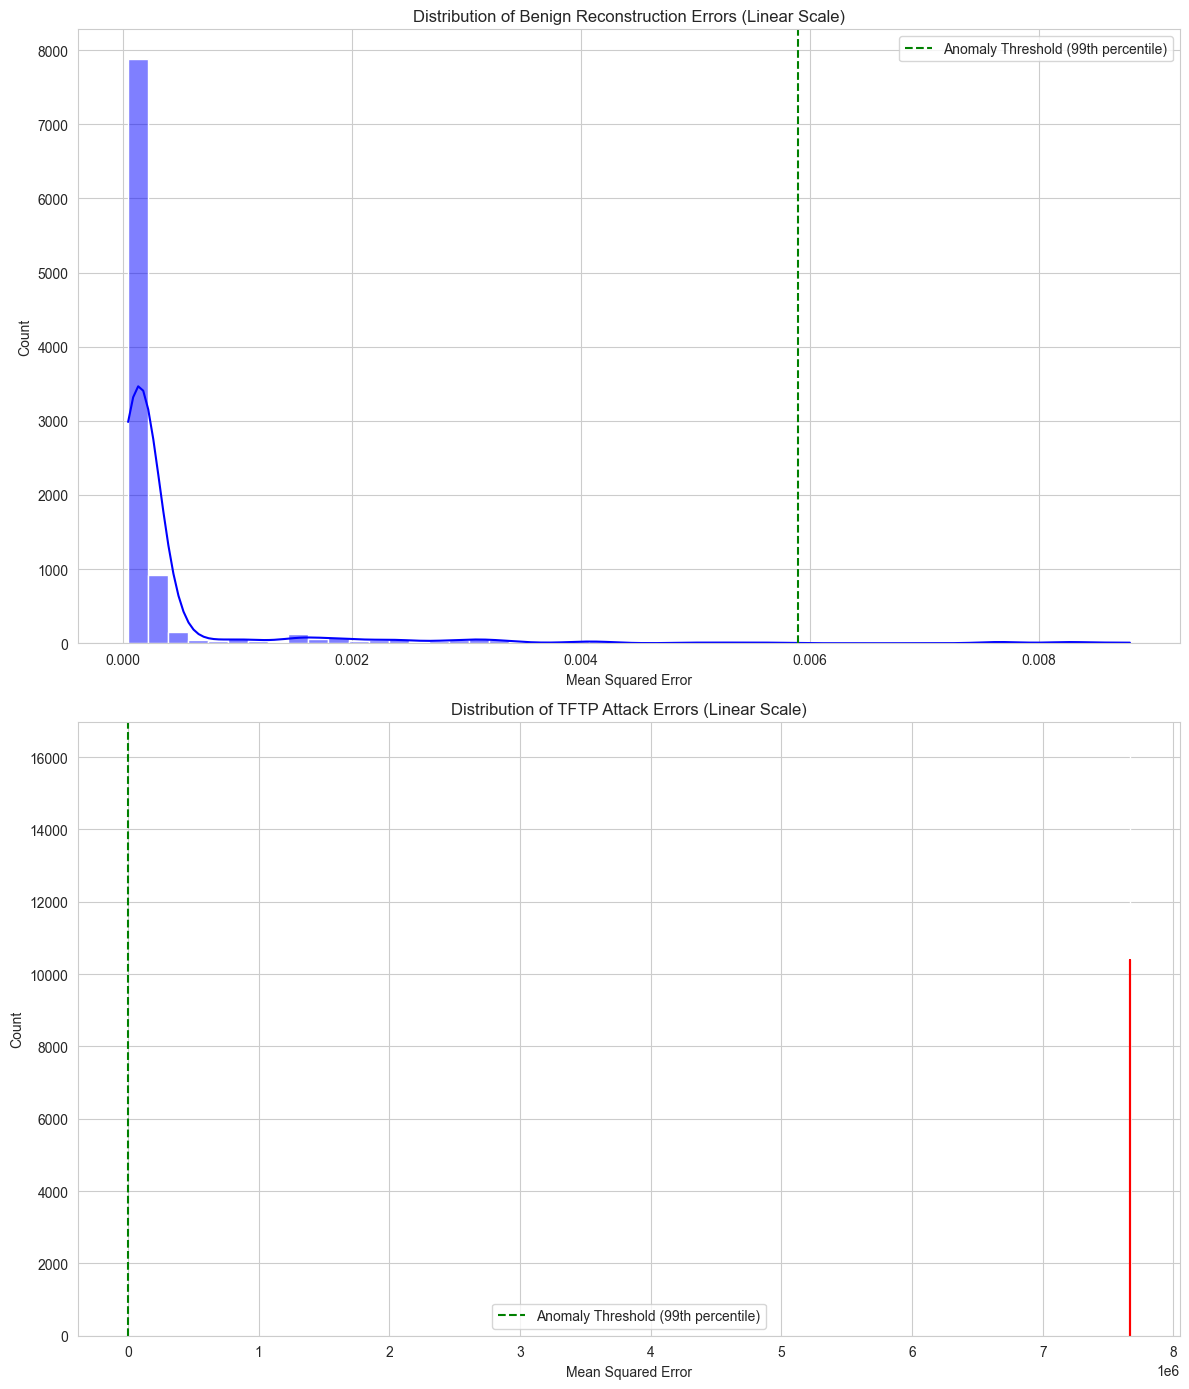


Insight: The two separate plots clearly show the massive difference in magnitude between benign and attack errors. The benign errors are clustered near zero, while the attack errors are orders of magnitude larger. This confirms the model can easily separate them, explaining the high accuracy.


In [ ]:
# --- Verification Step 2: Compare Error Distributions ---
print("\n--- Verification Step 2: Comparing Error Distributions ---")
if model and benign_reconstruction_errors:
    try:
        # Load a cached attack file
        attack_files_path = os.path.join('..', config.PROCESSED_DATA_DIR, 'X_attack_*.npy')
        attack_file_to_compare = glob(attack_files_path)[0]
        attack_type = os.path.basename(attack_file_to_compare).replace('X_attack_', '').replace('.npy', '')
        
        print(f"Loading '{attack_type}' sequences for error comparison...")
        attack_sequences = np.load(attack_file_to_compare)
        
        # Calculate reconstruction errors for the attack data
        attack_reconstruction_errors = []
        with torch.no_grad():
            dataset = TensorDataset(torch.tensor(attack_sequences, dtype=torch.float32))
            loader = DataLoader(dataset, batch_size=256)
            for batch in tqdm(loader, desc=f"Calculating '{attack_type}' Errors"):
                seqs = batch[0].to(config.DEVICE)
                reconstructions = model(seqs)
                errors = torch.mean((seqs - reconstructions) ** 2, dim=(1, 2))
                attack_reconstruction_errors.extend(errors.cpu().numpy())
        
        # --- FIX: Create two separate plots to visualize the different scales ---
        print("\n--- Error Statistics ---")
        print(f"Benign Errors - Mean: {np.mean(benign_reconstruction_errors):.4f}, Min: {np.min(benign_reconstruction_errors):.4f}, Max: {np.max(benign_reconstruction_errors):.4f}")
        print(f"Attack Errors - Mean: {np.mean(attack_reconstruction_errors):.4f}, Min: {np.min(attack_reconstruction_errors):.4f}, Max: {np.max(attack_reconstruction_errors):.4f}")

        fig, axes = plt.subplots(2, 1, figsize=(12, 14))
        
        # Plot 1: Benign Errors (Linear Scale)
        sns.histplot(benign_reconstruction_errors, ax=axes[0], bins=50, kde=True, color='blue')
        if threshold is not None:
            axes[0].axvline(threshold, color='green', linestyle='--', label=f'Anomaly Threshold (99th percentile)')
        axes[0].set_title('Distribution of Benign Reconstruction Errors (Linear Scale)')
        axes[0].set_xlabel('Mean Squared Error')
        axes[0].legend()

        # Plot 2: Attack Errors (Linear Scale)
        sns.histplot(attack_reconstruction_errors, ax=axes[1], bins=50, kde=True, color='red')
        if threshold is not None:
            axes[1].axvline(threshold, color='green', linestyle='--', label=f'Anomaly Threshold (99th percentile)')
        axes[1].set_title(f'Distribution of {attack_type} Attack Errors (Linear Scale)')
        axes[1].set_xlabel('Mean Squared Error')
        axes[1].legend()

        plt.tight_layout()
        plt.show()

        print("\nInsight: The two separate plots clearly show the massive difference in magnitude between benign and attack errors. The benign errors are clustered near zero, while the attack errors are orders of magnitude larger. This confirms the model can easily separate them, explaining the high accuracy.")

    except Exception as e:
        print(f"An error occurred during verification step 2: {e}")
else:
    print("Skipping Verification Step 2 because the model or benign errors are not available.")

